# Part 2: Quantization Aware Training with CIFAR

In this notebook, we explain the constraints that fully homomorphic encryption **(FHE)** imposes on neural networks and how to **quantize a custom pretrained** neural network to make in compatible with FHE.

In order to make inference of neural networks work with FHE, two main constraints must be respected :

- Quantization: the input data and model's weights and activations must be integers. In Concrete ML, this step is performed automatically for built-in models. In the case of Neural Networks, this is done using techniques such as Quantized Aware Training (QAT)through the use of [Brevitas](https://github.com/Xilinx/brevitas)

- Precision limitation: The current version of Concrete ML has a precision limitation of $16$-bits, i.e., it doesn't support encrypted values larger than $16$-bits integers

This notebook shows how to perform quantization aware training using Brevitas to solve a classification task on CIFAR-10 and CIFAR-100.

## Import the required packages.

In [2]:
import torch
from cifar_utils import (
    fhe_compatibility,
    get_dataloader,
    mapping_keys,
    plot_baseline,
    plot_dataset,
    torch_inference,
    train,
)

# As we follow the same methodology for quantization aware training for CIFAR-10 and CIFAR-100.
# Let's import some generic functions.
from modell import QuantVGG19
from torchvision import datasets

In [9]:
%pip uninstall torch torchvision -y  # Uninstall
%pip install torch torchvision  --extra-index-url https://download.pytorch.org/whl/cu117 # Reinstall


Found existing installation: torch 2.3.1
Uninstalling torch-2.3.1:
  Successfully uninstalled torch-2.3.1
Found existing installation: torchvision 0.18.1
Uninstalling torchvision-0.18.1:
  Successfully uninstalled torchvision-0.18.1
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
  Using cached torchvision-0.18.1-cp310-cp310-manylinux1_x86_64.whl (7.0 MB)
  Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl (779.1 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

In [2]:
%pip install torchvision
%pip install concrete-ml 
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached torchvision-0.18.1-cp310-cp310-manylinux1_x86_64.whl (7.0 MB)
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl (887.5 MB)
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1
    Uninstalling torch-2.3.1:
      Successfully uninstalled torch-2.3.1
  Rolling back uninstall of torch
  Moving to /user/HS401/kp01235/.local/lib/python3.10/site-packages/torch-2.3.1.dist-info/
   from /user/HS401/kp01235/.local/lib/python3.10/site-packages/~orch-2.3.1.dist-info
  Movi

## From torch to Brevitas network
 
 Brevitas offers a quantized version of almost all torch layers. So, to quantize an existing torch model, you need to convert each torch layer to its Brevitas  equivalent and provide some extra quantization parameters, like : 

- bit_width: quantization bits for activations
- weight_bit_width: quantization bits for weights
- weight_quant : quantization protocol for the weights
- act_quant : quantization protocol for the activations

To quantize the input data, you have to add a very first QuantIdentity layer. It's also possible to use un-variate Pytorch layers mixed in with Brevitas quantized layers. 

For instance with Brevitas, the [Fp32VGG11](models.py) shown in the first [notebook](FromImageNetToCifar.ipynb) becomes [QuantVGG11](models.py).

## Settings

In [7]:
bit = 5

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device Type: {device}")

Device Type: cuda


## 1. Quantization Aware Training (QAT) with CIFAR-100

In [7]:
param_c100 = {
    "output_size": 100,
    "batch_size": 128,
    "training": "quant",
    "dataset_name": "CIFAR_100",
    "dataset": datasets.CIFAR100,
    "mean": [0.485, 0.456, 0.406],
    "std": [0.229, 0.224, 0.225],
    "lr": 6e-5,
    "seed": 727,
    "epochs": 10,
    "gamma": 0.01,
    "milestones": [3, 5],
    "criterion": torch.nn.CrossEntropyLoss(),
    "accuracy_test": [],
    "accuracy_train": [],
    "loss_test_history": [],
    "loss_train_history": [],
    "dir": "./checkpoints/CIFAR_100",
    "pre_trained_path": "fp32/CIFAR_100_fp32_state_dict.pt",
}

### CIFAR-100 data-set

100%|██████████| 169001437/169001437 [00:09<00:00, 17404737.44it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


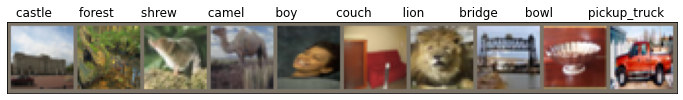

In [6]:
# Load CIFAR-100 data-set.
train_loader_c100, test_loader_c100 = get_dataloader(param=param_c100)

# Let’s visualize `n` images from CIFAR-100 data-set.
plot_dataset(test_loader_c100, param_c100)

### Quantized model

In [7]:
quant_vgg = QuantVGG19(bit=bit, output_size=param_c100["output_size"])

In this case, there are two possible scenarios: either we initialize the model's weights with those of the pre-trained model or we train the model from scratch. In this notebook, we have opted to use the first strategy. Please refer to the [first notebook](FromImageNetToCifar.ipynb) for additional details on how we managed to get the fp32 weights.

In [9]:
checkpoint = torch.load(
    f"{param_c100['dir']}/{param_c100['pre_trained_path']}", map_location=device
)

UnpicklingError: invalid load key, 'v'.

### Mapping keys

Caution: to load a pre-entrained fp32 state_dict into its equivalent quantized network it is necessary to have the same network architecture and same layer namings, otherwise it will raise an error.

The shift in the layer names in state_dict is due to the addition of QuantIdentity layers, that are necessary to ensure that the intermediate values of the model are all properly quantized.

In [7]:
quant_vgg = mapping_keys(checkpoint, quant_vgg, device)

### Accuracy before QAT

In [9]:
# It's better than a random classifier.

acc_before_ft = torch_inference(quant_vgg, test_loader_c100, device=device)
param_c100["accuracy_test"].append(acc_before_ft)

print(f"Top 1 accuracy before fine-tuning = {acc_before_ft * 100:.4f}%")

Top 1 accuracy before fine-tuning = 7.3217%


### FHE compatibility 

It's a good practice to first check the FHE-compatibility and whether homomorphic inference is achievable or not before moving on. 

To use this FHE simulation, the user needs to provide a representative set of data in order to determine the maximum bit-width within the circuit.

In [10]:
# The user can either provide the entire train data-set or a smaller but representative subset.
# As each batch is shuffled and contains 128 samples, it's a potential subset.

data_calibration, _ = next(iter(train_loader_c100))

qmodel = fhe_compatibility(quant_vgg, data_calibration)

print(
    f"With {param_c100['dataset_name']}, the maximum bit-width in the circuit = "
    f"{qmodel.fhe_circuit.graph.maximum_integer_bit_width()}"
)

### Fine-tuning using Quantization aware training (QAT) with Brevitas

For the fine-tuning approach, it is recommended to start with a low learning rate.

In [10]:
quant_vgg = train(quant_vgg, train_loader_c100, test_loader_c100, param_c100, device=device)

Epoch  0: Train loss = 0.5070 VS Test loss = 1.3996 - Accuracy train: 0.8428 VS Accuracy test: 0.6791
Epoch  1: Train loss = 0.3827 VS Test loss = 1.4884 - Accuracy train: 0.8800 VS Accuracy test: 0.6805
Epoch  2: Train loss = 0.3163 VS Test loss = 1.5556 - Accuracy train: 0.8996 VS Accuracy test: 0.6873
Epoch  3: Train loss = 0.2609 VS Test loss = 1.5615 - Accuracy train: 0.9170 VS Accuracy test: 0.6855
Epoch  4: Train loss = 0.2505 VS Test loss = 1.5604 - Accuracy train: 0.9189 VS Accuracy test: 0.6877
Epoch  5: Train loss = 0.2497 VS Test loss = 1.5592 - Accuracy train: 0.9218 VS Accuracy test: 0.6889
Epoch  6: Train loss = 0.2498 VS Test loss = 1.5576 - Accuracy train: 0.9219 VS Accuracy test: 0.6882
Epoch  7: Train loss = 0.2442 VS Test loss = 1.5540 - Accuracy train: 0.9222 VS Accuracy test: 0.6894
Epoch  8: Train loss = 0.2434 VS Test loss = 1.5576 - Accuracy train: 0.9228 VS Accuracy test: 0.6879
Epoch  9: Train loss = 0.2504 VS Test loss = 1.5537 - Accuracy train: 0.9205 VS Ac

100%|██████████| 78/78 [00:02<00:00, 32.94it/s]


Running time: 0.0002 sec.


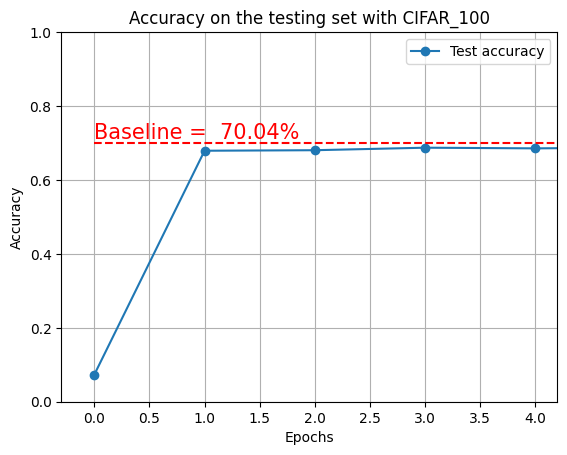

In [11]:
plot_baseline(param_c100, test_loader_c100, device)

As we can see, convergence occurs very quickly, in just one epoch we nearly reached the accuracy of the pre-trained model in fp32. The fine-tuning strategy appears to be quite efficient to save time and computating power.

If you choose to train the model from scratch, you'll need more epochs and a thorough understanding of the Brevitas framework to achieve good results.

## 2. Quantization Aware Training (QAT) with CIFAR-10

Since the methodology is the same, we do exactly the same thing but this time with the CIFAR-10 hyper-parameters.

In [8]:
param_c10 = {
    "output_size": 10,
    "batch_size": 128,
    "training": "quant",
    "dataset_name": "CIFAR_10",
    "dataset": datasets.CIFAR10,
    "std": [0.247, 0.243, 0.261],
    "mean": [0.4914, 0.4822, 0.4465],
    "seed": 42,
    "lr": 1e-5,
    "epochs": 9,
    "gamma": 0.1,
    "milestones": [4],
    "criterion": torch.nn.CrossEntropyLoss(),
    "accuracy_test": [],
    "accuracy_train": [],
    "loss_test_history": [],
    "loss_train_history": [],
    "dir": "./checkpoints/CIFAR_10",
    "pre_trained_path": "fp32/CIFAR_10_fp32_state_dict.pt",
}

### CIFAR-10 data-set

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


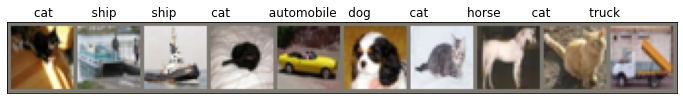

In [9]:
# Load CIFAR-10 data-set.

train_loader_c10, test_loader_c10 = get_dataloader(param=param_c10)

# Let’s visualize `n` images from CIFAR-100 data-set.

plot_dataset(test_loader_c10, param_c10)

### Quantized model

In [14]:
# Instantiate our custom vgg19 network.
quant_vgg = QuantVGG19(bit=bit, output_size=param_c10["output_size"]).to(device)

checkpoint = torch.load(f"{param_c10['dir']}/{param_c10['pre_trained_path']}", map_location=device)
# checkpoint = torch.load("./checkpoints/CIFAR_10/fp32/CIFAR10_fp32_weights_acc_0.9013.pt")

# Mapping keys.
quant_vgg = mapping_keys(checkpoint, quant_vgg, device)

### Accuracy before QAT

In [15]:
# It's better than a random classifier.

acc_before_ft = torch_inference(quant_vgg, test_loader_c10, device=device)
param_c10["accuracy_test"].append(acc_before_ft)

print(f"Top-1 accuracy before fine-tuning = {acc_before_ft * 100:.4f}%")

Top-1 accuracy before fine-tuning = 18.9002%


### FHE-compatibility

In [13]:
# Check the FHE-compatibility.
data, _ = next(iter(train_loader_c10))
qmodel = fhe_compatibility(quant_vgg, data)

print(
    f"With {param_c10['dataset_name']}, the circuit has a maximum bit-width of "
    f"{qmodel.fhe_circuit.graph.maximum_integer_bit_width()}-bits."
)

[W shape_type_inference.cpp:1968] Warning: The shape inference of onnx.brevitas::Quant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)
[W shape_type_inference.cpp:1968] Warning: The shape inference of onnx.brevitas::Quant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)


SymbolicValueError: Unsupported: ONNX export of convolution for kernel of unknown shape.  [Caused by the value 'x defined in (%x : Float(*, *, *, *, strides=[3072, 1024, 32, 1], requires_grad=0, device=cpu) = onnx.brevitas::Quant[narrow=0, rounding_mode="ROUND", signed=1](%x.1615, %scale, %zero_point, %bit_width), scope: modell.QuantVGG19::/torch.nn.modules.container.Sequential::features/brevitas.nn.quant_activation.QuantIdentity::features.0/brevitas.proxy.runtime_quant.ActQuantProxyFromInjector::act_quant/brevitas.export.onnx.qonnx.handler.BrevitasActQuantProxyHandler::export_handler # /user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/autograd/function.py:598:0
)' (type 'Tensor') in the TorchScript graph. The containing node has kind 'onnx.brevitas::Quant'.] 
    (node defined in /user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/autograd/function.py(598): apply
/user/HS401/kp01235/.local/lib/python3.10/site-packages/brevitas/export/onnx/qonnx/handler.py(49): symbolic_execution
/user/HS401/kp01235/.local/lib/python3.10/site-packages/brevitas/export/onnx/handler.py(114): forward
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/module.py(1522): _slow_forward
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/module.py(1541): _call_impl
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/module.py(1532): _wrapped_call_impl
/user/HS401/kp01235/.local/lib/python3.10/site-packages/brevitas/proxy/runtime_quant.py(150): forward
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/module.py(1522): _slow_forward
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/module.py(1541): _call_impl
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/module.py(1532): _wrapped_call_impl
/user/HS401/kp01235/.local/lib/python3.10/site-packages/brevitas/nn/quant_layer.py(148): forward
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/module.py(1522): _slow_forward
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/module.py(1541): _call_impl
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/module.py(1532): _wrapped_call_impl
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/container.py(217): forward
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/module.py(1522): _slow_forward
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/module.py(1541): _call_impl
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/module.py(1532): _wrapped_call_impl
/scratch/kp01235/cifar_brevitas_finetuning-20240715T194334Z-001/cifar_brevitas_finetuning/modell.py(141): forward
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/module.py(1522): _slow_forward
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/module.py(1541): _call_impl
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/module.py(1532): _wrapped_call_impl
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/jit/_trace.py(129): wrapper
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/jit/_trace.py(138): forward
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/module.py(1541): _call_impl
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/nn/modules/module.py(1532): _wrapped_call_impl
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/jit/_trace.py(1310): _get_trace_graph
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/onnx/utils.py(914): _trace_and_get_graph_from_model
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/onnx/utils.py(1010): _create_jit_graph
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/onnx/utils.py(1134): _model_to_graph
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/onnx/utils.py(1612): _export
/user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/onnx/utils.py(516): export
/user/HS401/kp01235/.local/lib/python3.10/site-packages/brevitas/export/onnx/manager.py(131): export_onnx
/user/HS401/kp01235/.local/lib/python3.10/site-packages/brevitas/export/onnx/manager.py(159): export
/user/HS401/kp01235/.local/lib/python3.10/site-packages/concrete/ml/torch/compile.py(518): compile_brevitas_qat_model
/scratch/kp01235/cifar_brevitas_finetuning-20240715T194334Z-001/cifar_brevitas_finetuning/cifar_utils.py(455): fhe_compatibility
/tmp/ipykernel_491718/311237316.py(3): <module>
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py(3457): run_code
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py(3377): run_ast_nodes
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py(3185): run_cell_async
/usr/lib/python3/dist-packages/IPython/core/async_helpers.py(78): _pseudo_sync_runner
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py(2960): _run_cell
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py(2914): run_cell
/usr/lib/python3/dist-packages/ipykernel/zmqshell.py(532): run_cell
/usr/lib/python3/dist-packages/ipykernel/ipkernel.py(353): do_execute
/usr/lib/python3/dist-packages/ipykernel/kernelbase.py(652): execute_request
/usr/lib/python3/dist-packages/ipykernel/kernelbase.py(357): dispatch_shell
/usr/lib/python3/dist-packages/ipykernel/kernelbase.py(450): process_one
/usr/lib/python3/dist-packages/ipykernel/kernelbase.py(461): dispatch_queue
/usr/lib/python3.10/asyncio/events.py(80): _run
/usr/lib/python3.10/asyncio/base_events.py(1909): _run_once
/usr/lib/python3.10/asyncio/base_events.py(603): run_forever
/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py(195): start
/usr/lib/python3/dist-packages/ipykernel/kernelapp.py(677): start
/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py(1046): launch_instance
/usr/lib/python3/dist-packages/ipykernel_launcher.py(16): <module>
/usr/lib/python3.10/runpy.py(86): _run_code
/usr/lib/python3.10/runpy.py(196): _run_module_as_main
)

    Inputs:
        #0: x.1615 defined in (%x.1615 : Float(1, 3, 32, 32, strides=[3072, 1024, 32, 1], requires_grad=0, device=cpu), %features.1.weight : Float(64, 3, 3, 3, strides=[27, 9, 3, 1], requires_grad=1, device=cpu), %features.1.bias : Float(64, strides=[1], requires_grad=1, device=cpu), %features.3.weight : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=1, device=cpu), %features.3.bias : Float(64, strides=[1], requires_grad=1, device=cpu), %features.7.weight : Float(128, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=1, device=cpu), %features.7.bias : Float(128, strides=[1], requires_grad=1, device=cpu), %features.9.weight : Float(128, 128, 3, 3, strides=[1152, 9, 3, 1], requires_grad=1, device=cpu), %features.9.bias : Float(128, strides=[1], requires_grad=1, device=cpu), %features.13.weight : Float(256, 128, 3, 3, strides=[1152, 9, 3, 1], requires_grad=1, device=cpu), %features.13.bias : Float(256, strides=[1], requires_grad=1, device=cpu), %features.15.weight : Float(256, 256, 3, 3, strides=[2304, 9, 3, 1], requires_grad=1, device=cpu), %features.15.bias : Float(256, strides=[1], requires_grad=1, device=cpu), %features.17.weight : Float(256, 256, 3, 3, strides=[2304, 9, 3, 1], requires_grad=1, device=cpu), %features.17.bias : Float(256, strides=[1], requires_grad=1, device=cpu), %features.19.weight : Float(256, 256, 3, 3, strides=[2304, 9, 3, 1], requires_grad=1, device=cpu), %features.19.bias : Float(256, strides=[1], requires_grad=1, device=cpu), %features.23.weight : Float(512, 256, 3, 3, strides=[2304, 9, 3, 1], requires_grad=1, device=cpu), %features.23.bias : Float(512, strides=[1], requires_grad=1, device=cpu), %features.25.weight : Float(512, 512, 3, 3, strides=[4608, 9, 3, 1], requires_grad=1, device=cpu), %features.25.bias : Float(512, strides=[1], requires_grad=1, device=cpu), %features.27.weight : Float(512, 512, 3, 3, strides=[4608, 9, 3, 1], requires_grad=1, device=cpu), %features.27.bias : Float(512, strides=[1], requires_grad=1, device=cpu), %features.29.weight : Float(512, 512, 3, 3, strides=[4608, 9, 3, 1], requires_grad=1, device=cpu), %features.29.bias : Float(512, strides=[1], requires_grad=1, device=cpu), %features.33.weight : Float(512, 512, 3, 3, strides=[4608, 9, 3, 1], requires_grad=1, device=cpu), %features.33.bias : Float(512, strides=[1], requires_grad=1, device=cpu), %features.35.weight : Float(512, 512, 3, 3, strides=[4608, 9, 3, 1], requires_grad=1, device=cpu), %features.35.bias : Float(512, strides=[1], requires_grad=1, device=cpu), %features.37.weight : Float(512, 512, 3, 3, strides=[4608, 9, 3, 1], requires_grad=1, device=cpu), %features.37.bias : Float(512, strides=[1], requires_grad=1, device=cpu), %features.39.weight : Float(512, 512, 3, 3, strides=[4608, 9, 3, 1], requires_grad=1, device=cpu), %features.39.bias : Float(512, strides=[1], requires_grad=1, device=cpu), %final_layer.weight : Float(10, 512, strides=[512, 1], requires_grad=1, device=cpu), %final_layer.bias : Float(10, strides=[1], requires_grad=1, device=cpu) = prim::Param()
    )  (type 'Tensor')
        #1: scale defined in (%scale : Float(requires_grad=0, device=cpu) = onnx::Constant[value={0.0625}](), scope: modell.QuantVGG19::/torch.nn.modules.container.Sequential::features/brevitas.nn.quant_activation.QuantIdentity::features.0/brevitas.proxy.runtime_quant.ActQuantProxyFromInjector::act_quant/brevitas.export.onnx.qonnx.handler.BrevitasActQuantProxyHandler::export_handler # /user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/autograd/function.py:598:0
    )  (type 'Tensor')
        #2: zero_point defined in (%zero_point : Float(requires_grad=0, device=cpu) = onnx::Constant[value={0}](), scope: modell.QuantVGG19::/torch.nn.modules.container.Sequential::features/brevitas.nn.quant_activation.QuantIdentity::features.0/brevitas.proxy.runtime_quant.ActQuantProxyFromInjector::act_quant/brevitas.export.onnx.qonnx.handler.BrevitasActQuantProxyHandler::export_handler # /user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/autograd/function.py:598:0
    )  (type 'Tensor')
        #3: bit_width defined in (%bit_width : Float(requires_grad=0, device=cpu) = onnx::Constant[value={5}](), scope: modell.QuantVGG19::/torch.nn.modules.container.Sequential::features/brevitas.nn.quant_activation.QuantIdentity::features.0/brevitas.proxy.runtime_quant.ActQuantProxyFromInjector::act_quant/brevitas.export.onnx.qonnx.handler.BrevitasActQuantProxyHandler::export_handler # /user/HS401/kp01235/.local/lib/python3.10/site-packages/brevitas/export/onnx/qonnx/handler.py:46:0
    )  (type 'Tensor')
    Outputs:
        #0: x defined in (%x : Float(*, *, *, *, strides=[3072, 1024, 32, 1], requires_grad=0, device=cpu) = onnx.brevitas::Quant[narrow=0, rounding_mode="ROUND", signed=1](%x.1615, %scale, %zero_point, %bit_width), scope: modell.QuantVGG19::/torch.nn.modules.container.Sequential::features/brevitas.nn.quant_activation.QuantIdentity::features.0/brevitas.proxy.runtime_quant.ActQuantProxyFromInjector::act_quant/brevitas.export.onnx.qonnx.handler.BrevitasActQuantProxyHandler::export_handler # /user/HS401/kp01235/.local/lib/python3.10/site-packages/torch/autograd/function.py:598:0
    )  (type 'Tensor')

In [13]:
print(quant_vgg)

QuantVGG19(
  (features): Sequential(
    (0): QuantIdentity(
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (export_handler): BrevitasActQuantProxyHandler()
      )
      (act_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (fused_activation_quant_proxy): FusedActivationQuantProxy(
          (activation_impl): Identity()
          (tensor_quant): RescalingIntQuant(
            (int_quant): IntQuant(
              (float_to_int_impl): RoundSte()
              (tensor_clamp_impl): TensorClamp()
              (delay_wrapper): DelayWrapper(
                (delay_impl): _NoDelay()
              )
            )
            (scaling_impl): ParameterFromRuntimeStatsScaling(
              (stats_input_view_shape_impl): OverTensorView()
              (stats): _Stats(
                (stats_impl): AbsPercentile()
              )
              (restrict_scaling): _RestrictValue(
                (res

### Fine-tuning using Quantization aware training (QAT) with Brevitas

In [17]:
# Quantization Aware Training.
quant_vgg = train(quant_vgg, train_loader_c10, test_loader_c10, param_c10, device=device)

  0%|          | 0/9 [00:00<?, ?it/s]


KeyError: 140104705903104

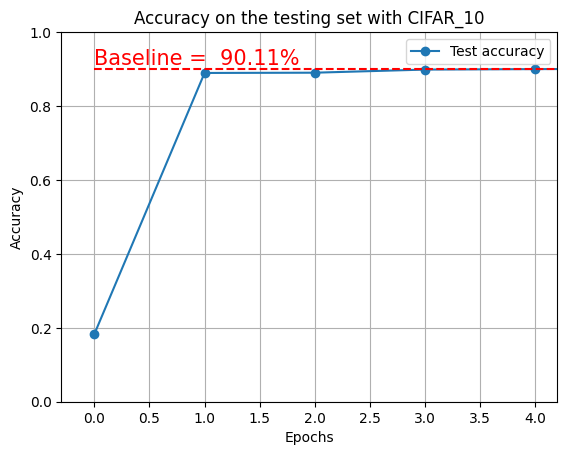

In [18]:
plot_baseline(param_c10, test_loader_c10, device)

After $3$ epochs, we reached the accuracy of the pre-trained model in fp32.

# Conclusion

By initializing the Brevitas FHE-friendly network with pre-trained fp32 weights and using quantization aware training approach we can see that the convergence is extremely fast, after one epoch we nearly catch up with the baseline in fp32.

However, the quantization process could cause a slight decrease in performance.

Data-set     | Top1-accuracy with Brevitas | Top1-accuracy with Pytorch 
-------------|---------------------------- |---------------------------
CIFAR-10     | $90.42$%                    | $90.11$%  
CIFAR-100    | $68.46$%                    | $70.43$%   


In this notebook, we have explained why we need to quantize a model, how to check if a network is FHE-compliant and how to quantize an fp32 pre-trained model using Quantization Aware Training (QAT) with Bravitas.

In the third [notebook](CifarInFhe.ipynb), we will show how to evaluate a quantized model in FHE. 